In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32 # each batch contain 32 images
EPOOCH = 5
CHANNELS = 3


In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE )

Found 4152 files belonging to 5 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Septoria_leaf_spot']

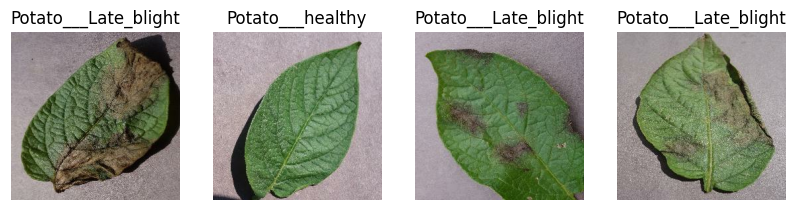

In [5]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1): # it gives you 1 batch
    for i in range(4): # to diaplay some images
        ax = plt.subplot(1,4,i+1) # no. of rows, no. of cols, position of current image 
        plt.imshow(image_batch[i].numpy().astype('uint8')) # it expects 3d array of image
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [6]:
train_size = 0.8
len(dataset) * train_size

104.0

In [7]:
train_ds = dataset.take(54)
len(train_ds)

54

In [8]:
test_ds = dataset.skip(54) # remaining datset after 54

In [9]:
valid_size = 0.1
len(dataset) * valid_size

13.0

In [10]:
test_size = test_ds.skip(6)
len(test_size)

70

In [11]:
valid_ds = test_ds.take(6)

In [12]:
test_ds = test_ds.skip(6)

In [13]:
def splitting_data(dataset, train_split = 0.8, test_split = 0.1, val_split = 0.1, shuffle = True, shuffle_size = 100000):
    ds_size = len(dataset)
    
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed = 12)
        
        
    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)
    
    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds



In [14]:
train_ds, val_ds, test_ds = splitting_data(dataset)

In [15]:
len(train_ds)

104

In [16]:
len(val_ds)

13

In [17]:
len(test_ds)

13

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
    
])

In [20]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal'),
    layers.experimental.preprocessing.RandomRotation(0.2)
    
])

In [21]:
# neural network architecture

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5
# model building with set of layers  like rescale, resize, data augmentation, cnn layer
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3),activation = 'relu', input_shape = input_shape), # no. of layers(trail and error), actual filter size,activation layer
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3,3),activation = 'relu'), # no. of layers(trail and error), actual filter size,activation layer
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3,3),activation = 'relu'), 
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3),activation = 'relu'), 
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3),activation = 'relu', input_shape = input_shape), 
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3),activation = 'relu'), 
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
    
])

model.build(input_shape = input_shape)

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [23]:
# history of every epoch
history = model.fit(
    train_ds,
    epochs = EPOOCH,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/5
104/104 [==============================] - 343s 3s/step - loss: 1.2896 - accuracy: 0.4313 - val_loss: 0.9694 - val_accuracy: 0.6058
Epoch 2/5
104/104 [==============================] - 389s 4s/step - loss: 0.7839 - accuracy: 0.6970 - val_loss: 1.1427 - val_accuracy: 0.6370
Epoch 3/5
104/104 [==============================] - 357s 3s/step - loss: 0.4832 - accuracy: 0.8262 - val_loss: 0.8562 - val_accuracy: 0.7428
Epoch 4/5
104/104 [==============================] - 573s 6s/step - loss: 0.3305 - accuracy: 0.8849 - val_loss: 0.3027 - val_accuracy: 0.8822
Epoch 5/5
104/104 [==============================] - 402s 4s/step - loss: 0.2758 - accuracy: 0.9030 - val_loss: 0.4315 - val_accuracy: 0.8341


In [24]:
scores = model.evaluate(test_ds) #

13/13 [==============================] - 25s 748ms/step - loss: 0.5526 - accuracy: 0.7981


In [30]:
scores

[0.7065718173980713, 0.7644230723381042]

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

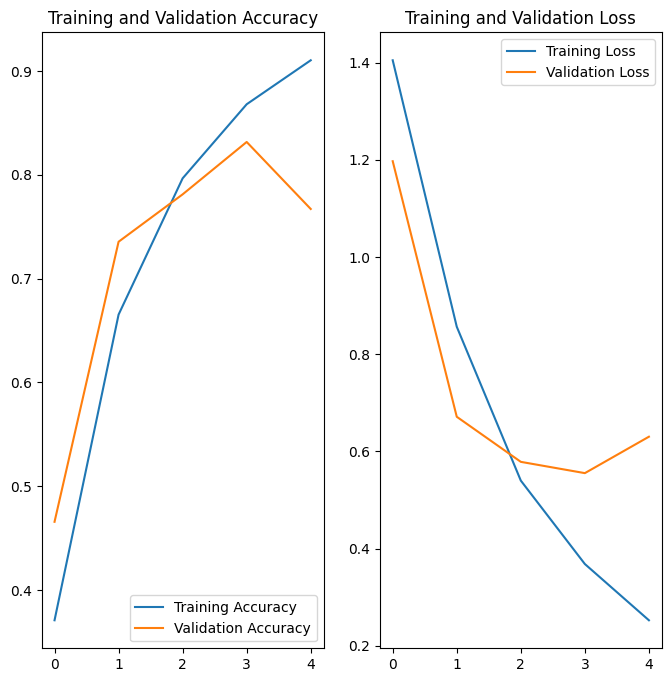

In [32]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOOCH), acc, label = 'Training Accuracy')
plt.plot(range(EPOOCH), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOOCH), loss, label = 'Training Loss')
plt.plot(range(EPOOCH), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
first images actual label: Potato___Late_blight
1/1 [==============================] - 1s 938ms/step
Predicted label :  Potato___Early_blight


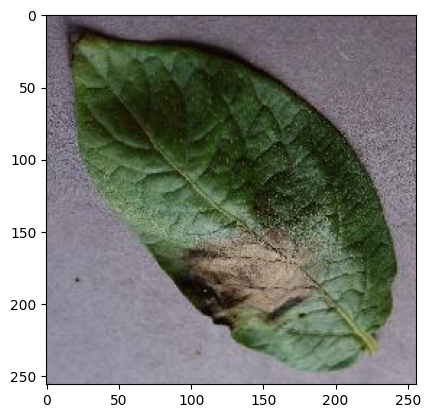

In [33]:
for image_batch, label_batch in test_ds.take(1):
    first_image =  image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    
    print('first image to predict')
    plt.imshow(first_image)
    
    print('first images actual label:',class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print('Predicted label : ',class_names[np.argmax(batch_prediction[0])])

In [34]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 63ms/step


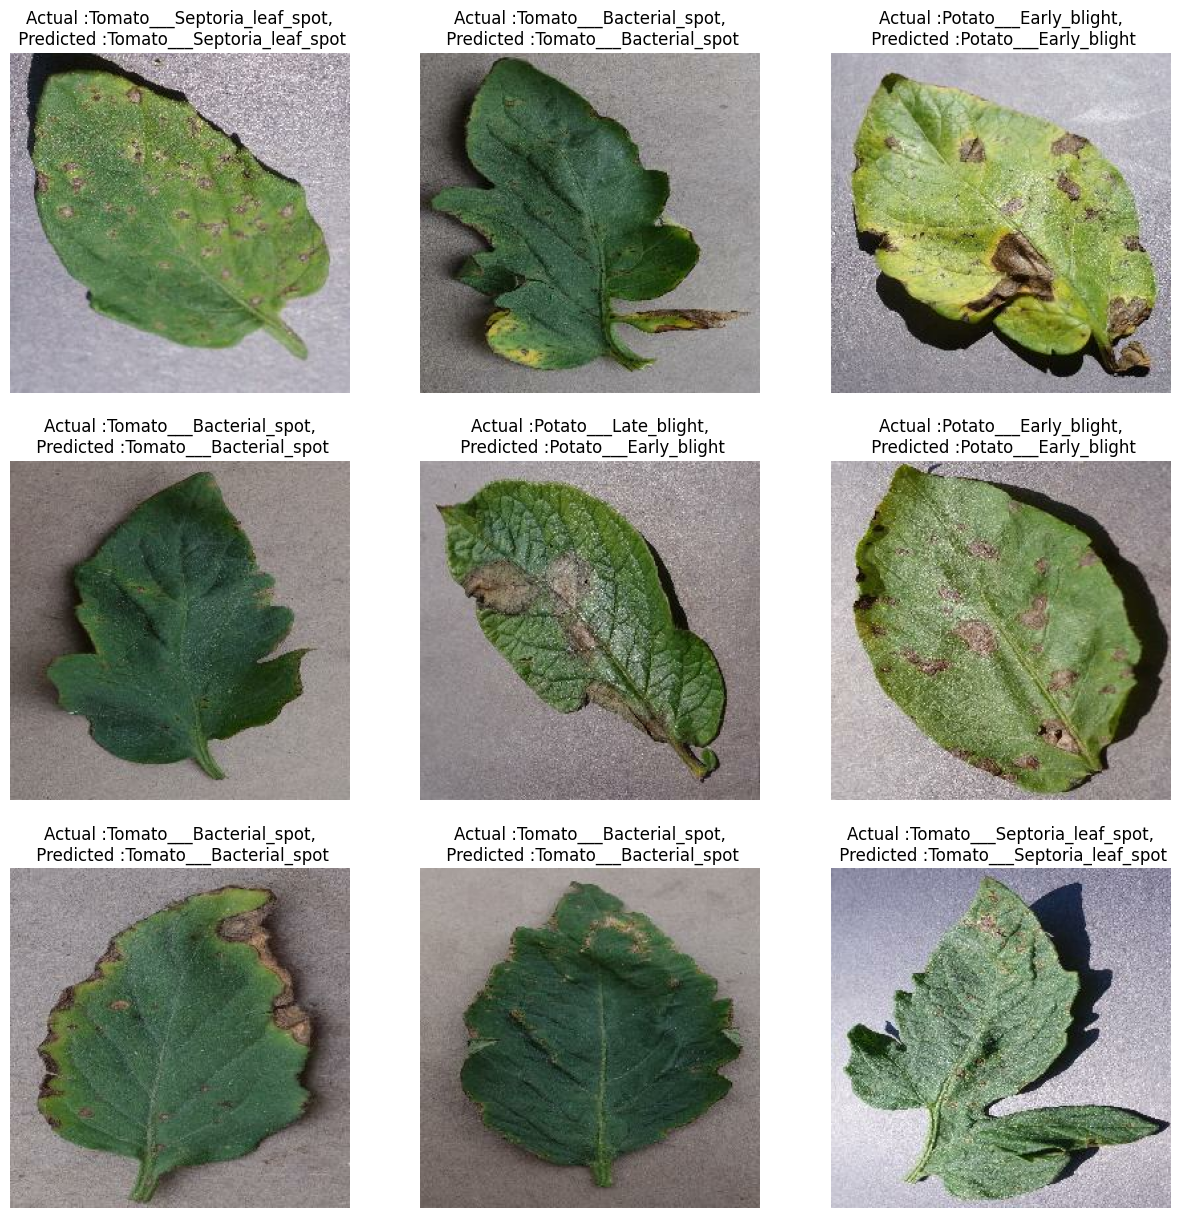

In [35]:
plt.figure(figsize = (15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(f"Actual :{actual_class},\n Predicted :{predicted_class}")
        
        plt.axis('off')

In [40]:
model_version = 5
model.save(f"./model/{model_version}")

INFO:tensorflow:Assets written to: ./model/5\assets


INFO:tensorflow:Assets written to: ./model/5\assets


In [32]:
import pickle

In [34]:
pickle.dump(model, open('iri.pkl','wb'))